# 1 可视化整个模型中的输入输出，方便分析

In [1]:
#---------------------------------#
#  预备工作：
#  导入库
#  加载配置文件
#  加载模型，加载数据集
#---------------------------------#

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from configs.config import get_config
from models.graphModel import GraphModel
from utils.graphDataset import GraphDataset
cfg = get_config()



d:\anaconda3\envs\2torch1.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg.JSON_PATH = r'configs\train_MOT17.json'
test_dataset = GraphDataset(cfg,'Validation',False)
# raw_tra_graph,raw_det_graph,gt_matrix = test_dataset.__getitem__(2100)

[Validation] Data-preprocess: 100%|██████████| 1/1 [00:00<00:00,  1.99dataset/s]
2024-12-31 17:36:58.862 | INFO     | utils.graphDataset:__init__:96 - [Validation] Total frame number : 2652


In [3]:
# k=13
# cfg.BT_DIRECTED = True
# cfg.K_NEIGHBOR  = k
# cfg.BT_SELF_LOOP= False
model = GraphModel(cfg.MODEL_YAML_PATH)
checkpoint = torch.load(r'model_weights\DA_120epoch.pth',map_location='cpu')
model.load_state_dict(checkpoint["model"], strict=False)

<All keys matched successfully>

In [4]:
model.edgeEncoder.bt_self_loop = False

In [5]:
model.edgeEncoder.bt_self_loop,model.edgeEncoder.bt_cosine

(False, False)

In [5]:
from tqdm import tqdm
for i in tqdm(range(0,len(test_dataset))):
    raw_tra_graph,raw_det_graph,gt_matrix = test_dataset.__getitem__(i)
    # print(raw_tra_graph.num_nodes)
    if raw_det_graph.num_nodes == 1 or raw_tra_graph.num_nodes == 1:
        print(i)
        break
raw_tra_graph,raw_det_graph

100%|██████████| 2652/2652 [03:09<00:00, 13.99it/s]


(Data(x=[7, 3, 256, 128], location_info=[7, 8]),
 Data(x=[6, 3, 256, 128], location_info=[6, 8]))

In [30]:

import sys
def get_size_KB(obj, seen=None):
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size_KB(v, seen) for v in obj.values()])
        size += sum([get_size_KB(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size_KB(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size_KB(i, seen) for i in obj])
    return size /1024

get_size_KB(test_dataset.dets_dict)

2.306289483505232

## 1.1 轨迹图与检测图节点 原始像素可视化

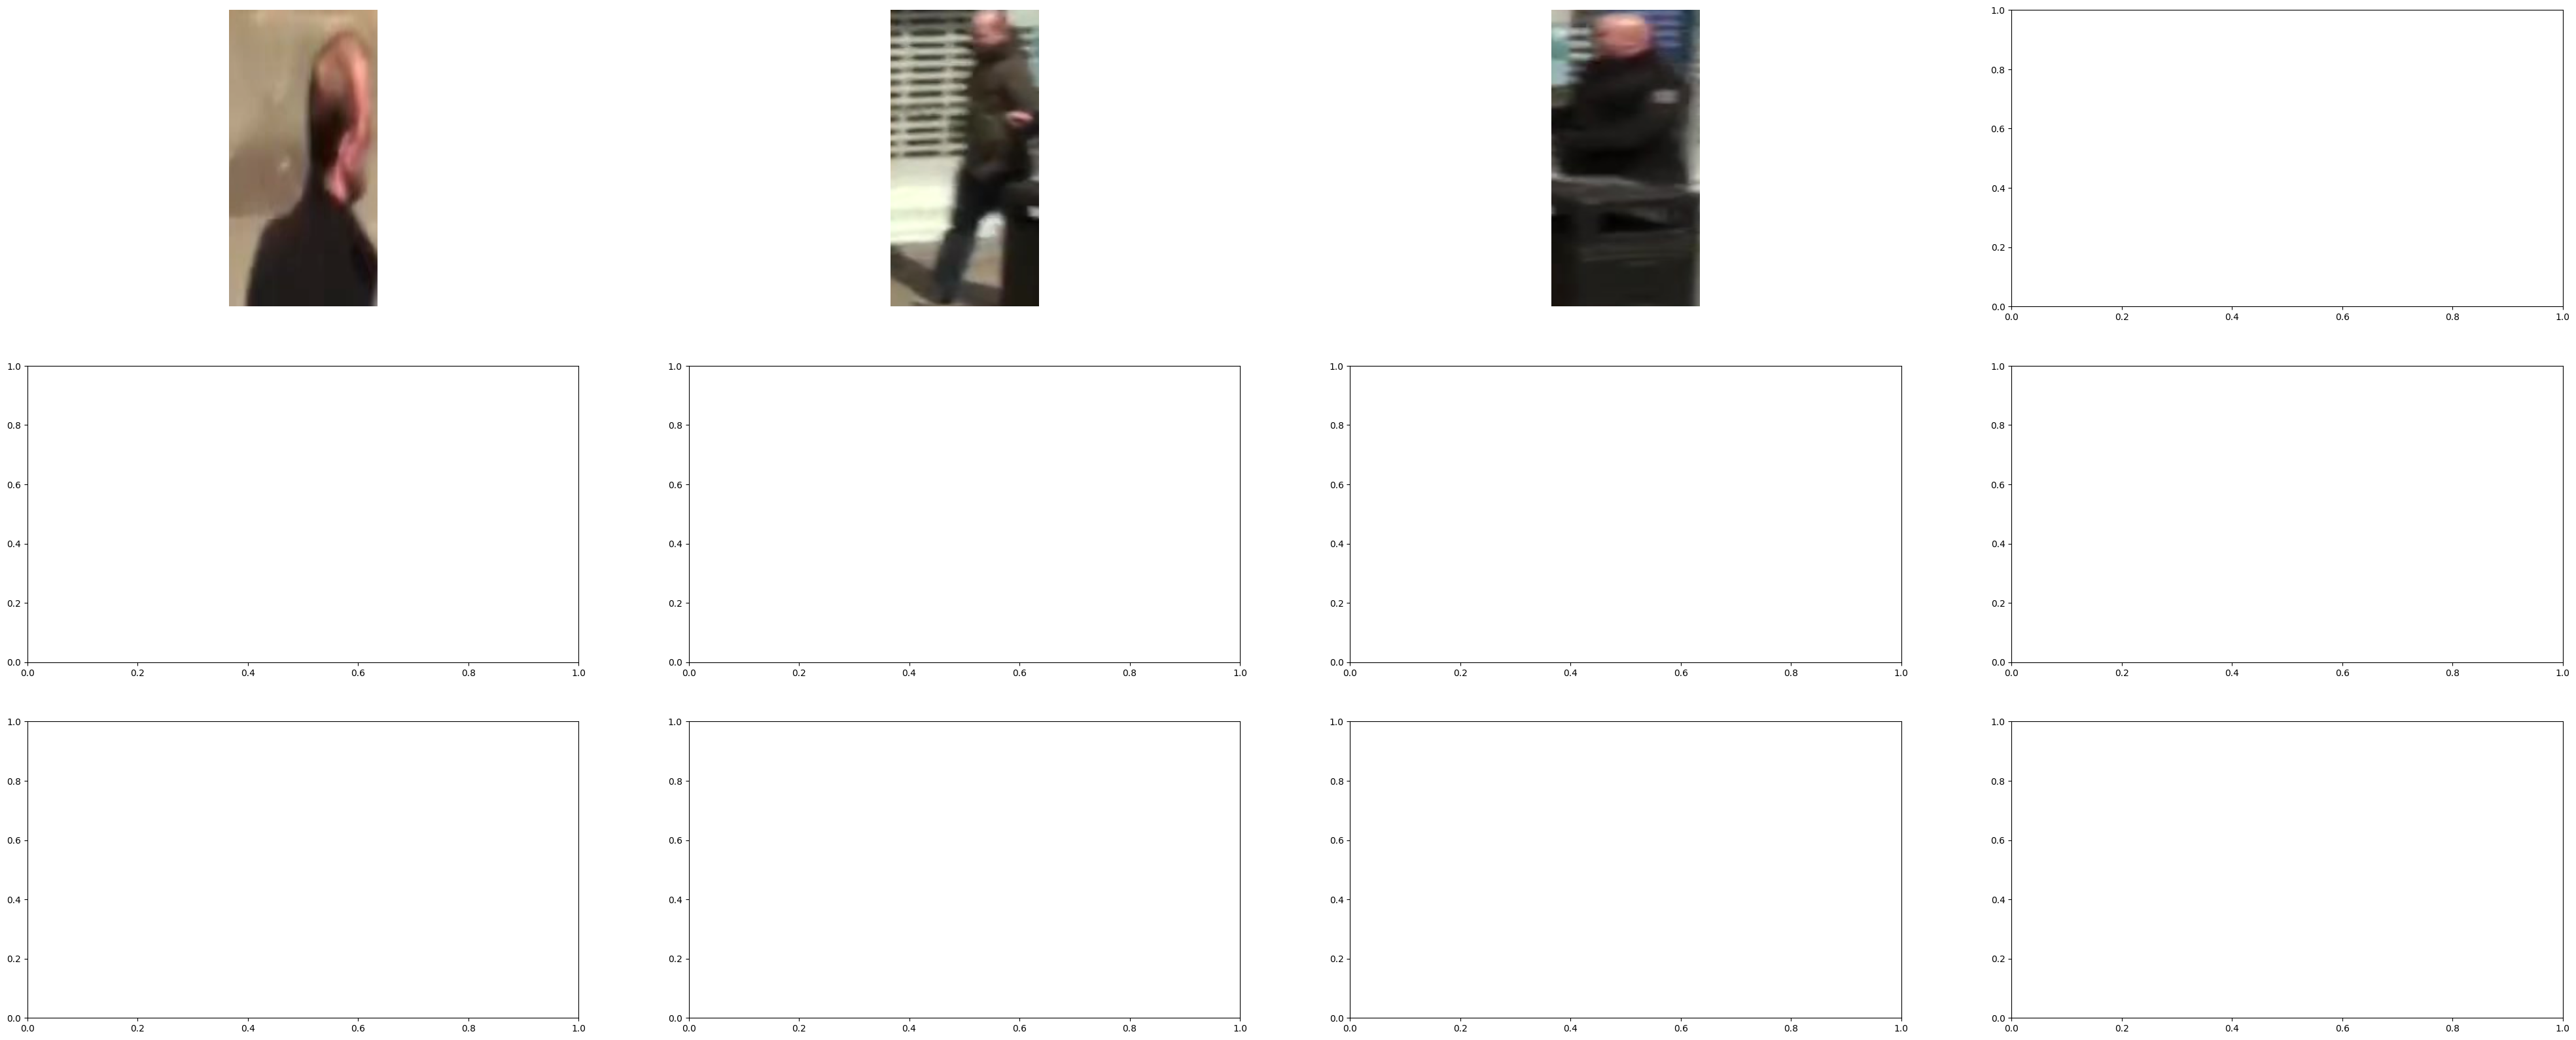

In [32]:
import math
from matplotlib import pyplot as plt
def scale_patch_to_0_1(patch):
    """将裁剪后的图像patch缩放到[0, 1]范围内"""
    patch_max = torch.max(patch)
    patch_min = torch.min(patch)
    patch = (patch - patch_min) / (patch_max - patch_min)  # 确保像素值在 [0, 1] 范围
    return patch 
# import torchvision.transforms.functional as F
tra_obj_ims = raw_tra_graph.x
num_tra    = tra_obj_ims.shape[0] 
num_rows = math.ceil(num_tra )
fig, axs   = plt.subplots(num_rows, 4, figsize=(50, 20))
# # plt.imshow(tra_obj_im)

for i in range(num_tra):
    row = i //4
    col = i % 4
    patch = scale_patch_to_0_1(tra_obj_ims[i])
    # print(patch.shape)
    axs[row,col].imshow(patch.permute(1,2,0).numpy())
    axs[row,col].axis('off')
plt.show()

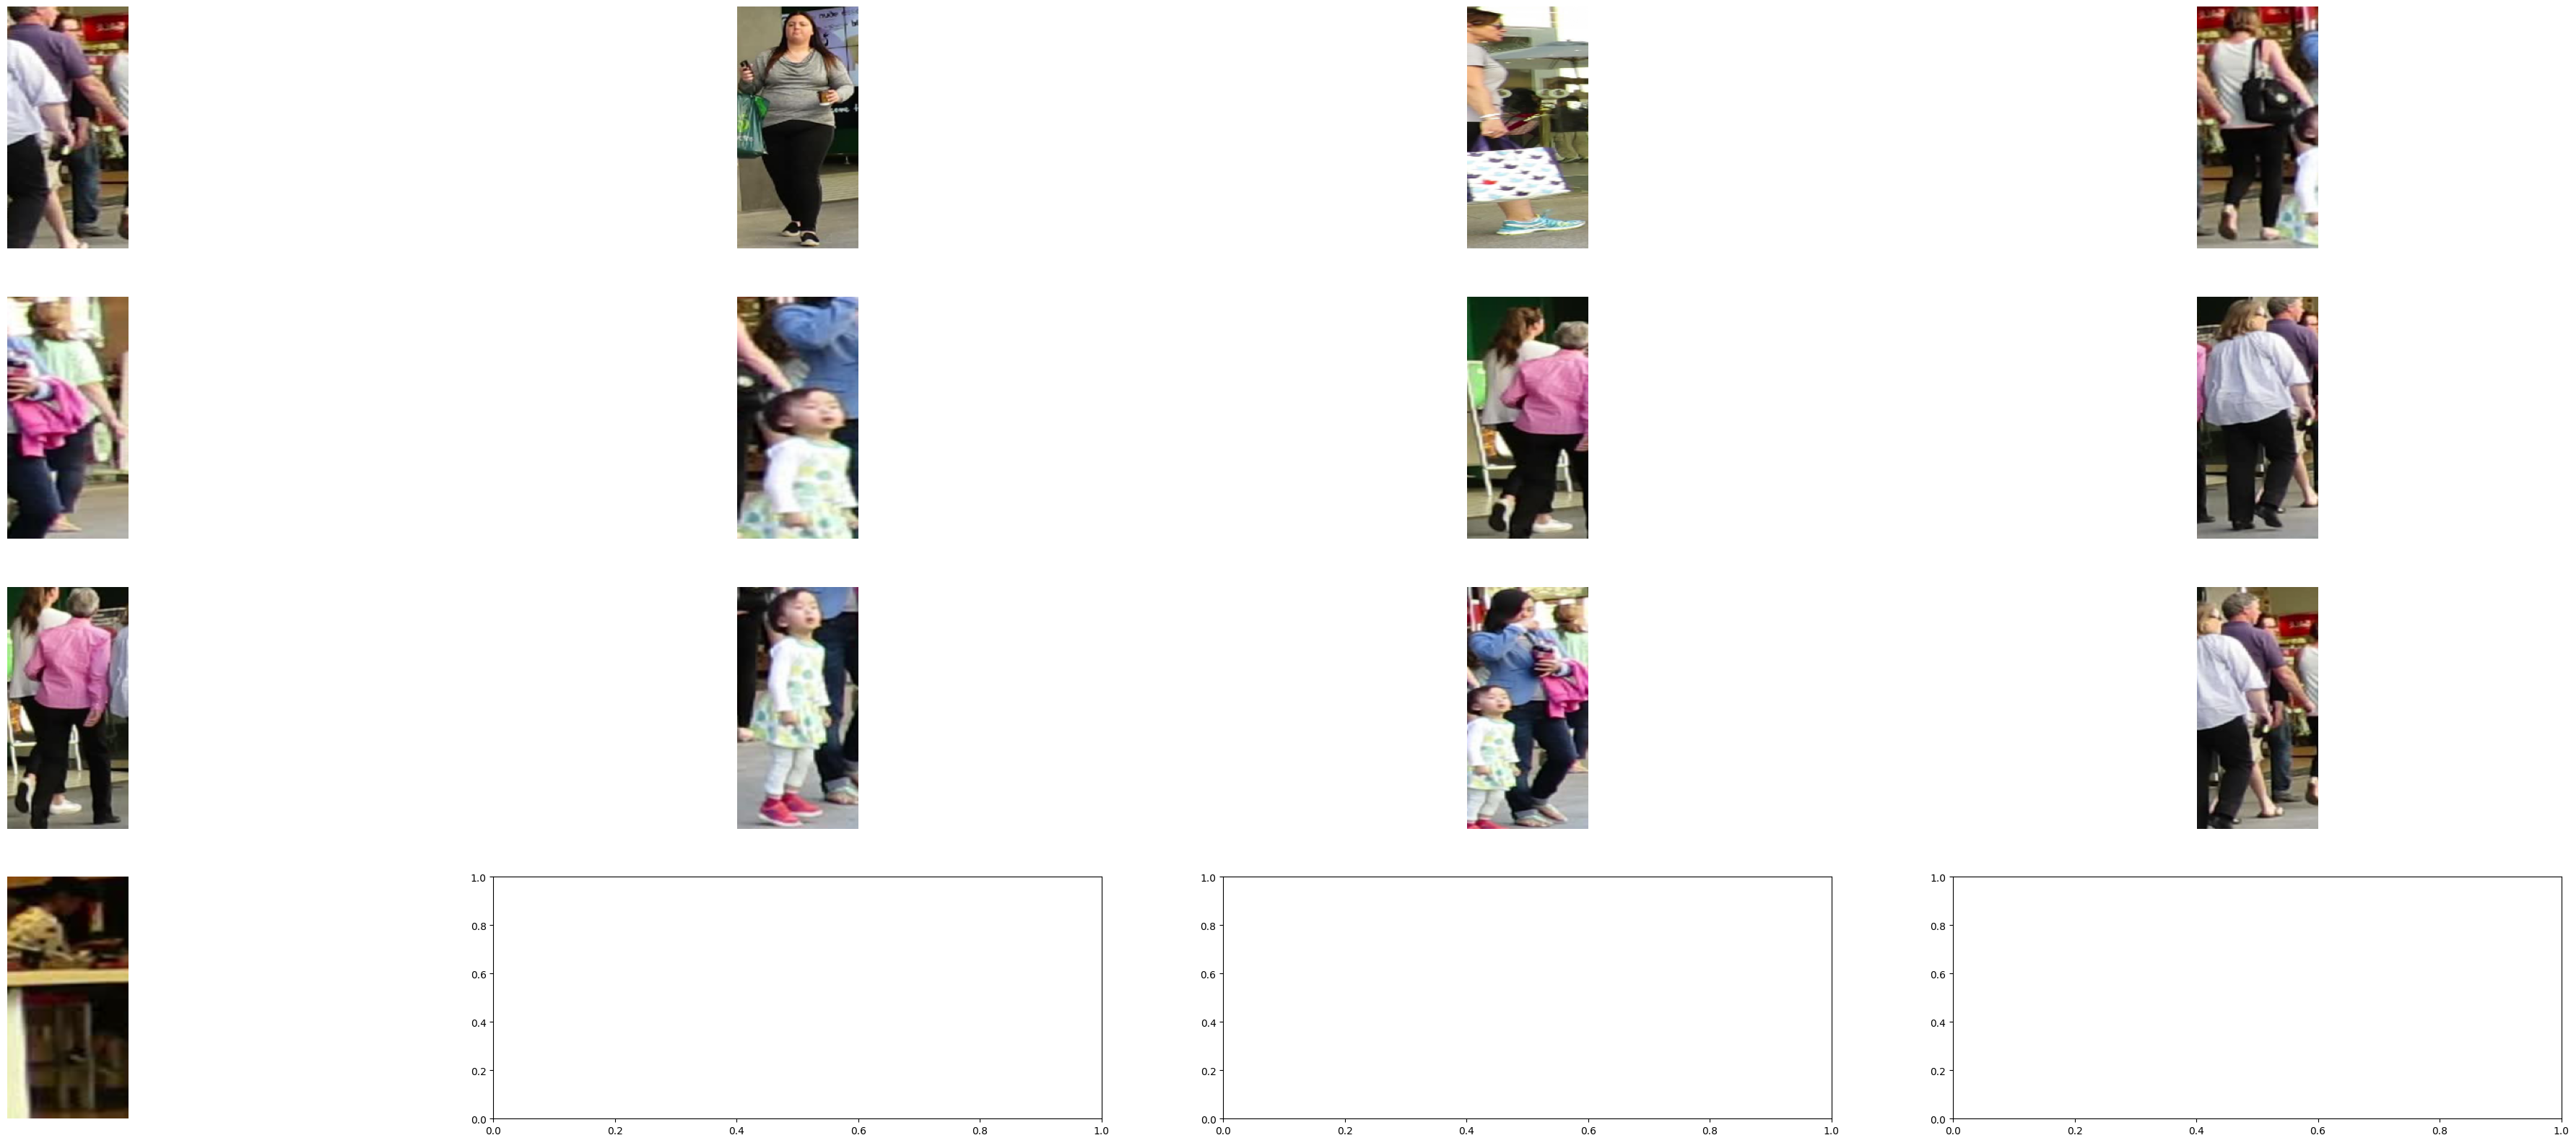

In [8]:
det_obj_ims = raw_det_graph.x
num_tra    = det_obj_ims.shape[0] 
num_rows = math.ceil(num_tra / 4)
fig, axs   = plt.subplots(num_rows, 4, figsize=(50, 20))
# # plt.imshow(tra_obj_im)

for i in range(num_tra):
    row = i //4
    col = i % 4
    patch = scale_patch_to_0_1(det_obj_ims[i])
    axs[row,col].imshow(patch.permute(1,2,0).numpy())
    axs[row,col].axis('off')
plt.show()

## 1.2 轨迹图与检测图经过Node Encoder之后的热力图

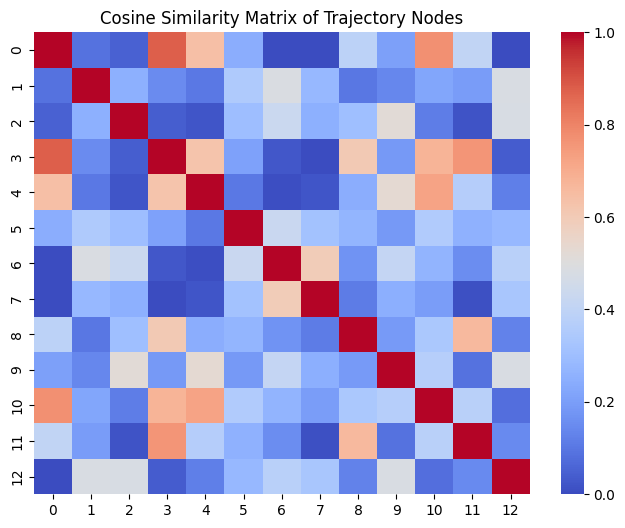

In [8]:
tra_graph = model.nodeEncoder(raw_tra_graph.clone())
det_graph = model.nodeEncoder(raw_det_graph.clone())

import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F 

#---------------------------------#
#  轨迹图
#---------------------------------#


node_embed = tra_graph.x
cos_sim_matrix = F.cosine_similarity(node_embed.unsqueeze(0), node_embed.unsqueeze(1), dim=2)
plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(cos_sim_matrix.detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("Cosine Similarity Matrix of Trajectory Nodes")

# 显示图像
plt.show()

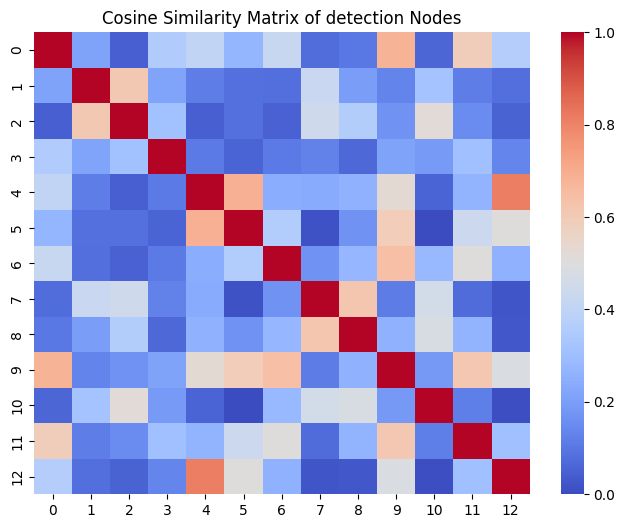

In [10]:
node_embed = det_graph.x
cos_sim_matrix = F.cosine_similarity(node_embed.unsqueeze(0), node_embed.unsqueeze(1), dim=2)
plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(cos_sim_matrix.detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("Cosine Similarity Matrix of detection Nodes")

# 显示图像
plt.show()

## 1.3 经过EdgeEncoder  完成图的构建之后，可视化图

In [14]:
tra_graph,tra_graph.edge_index,tra_graph.location_info[:,-2:]

(Data(x=[13, 32], location_info=[13, 8], edge_index=[2, 39], edge_attr=[39, 16]),
 tensor([[10,  6,  5,  7,  4,  0,  9,  4,  9,  2,  7,  6, 10,  0,  5,  6,  4,  9,
           4,  3,  0,  6, 12,  1, 11,  1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
          10, 11, 12],
         [ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
           9,  9, 10, 10, 11, 11, 12, 12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
          10, 11, 12]]),
 tensor([[1633.5000,  540.5000],
         [1178.5000,  567.5000],
         [1705.5000,  548.0000],
         [1852.0000,  529.0000],
         [1755.0000,  550.0000],
         [1456.0000,  538.0000],
         [1575.0000,  558.5000],
         [1476.5000,  558.0000],
         [1758.0000,  630.0000],
         [1795.5000,  554.5000],
         [1623.5000,  538.0000],
         [ 279.0000,  599.0000],
         [  -8.5000,  632.5000]]))

In [9]:
tra_graph = model.edgeEncoder(tra_graph,model.k)
det_graph = model.edgeEncoder(det_graph,model.k)

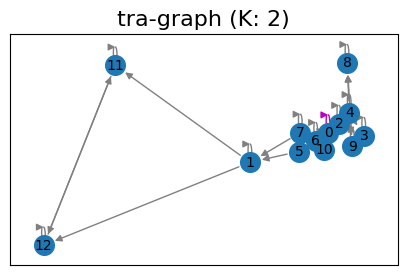

In [20]:
#---------------------------------#
#  带有边颜色的画图  不同K
#---------------------------------#
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

# Convert your graph to NetworkX and prepare positions
pos_dict = {}
for idx, pos in enumerate(tra_graph.location_info[:, :2]):
    pos_dict[idx] = pos.numpy()

G_tra = to_networkx(tra_graph, to_undirected=False)

# Plot the graph
plt.figure(figsize=(5, 3))

# Draw nodes with better visualization parameters
nx.draw_networkx_nodes(
    G_tra,
    pos=pos_dict,
    node_size=200,  # Increase node size
    # node_color='w',  # Set node color
)

# Draw edges with better visualization parameters
edge_colors = ['m' if edge[1] == 0 else 'grey' for edge in G_tra.edges]
nx.draw_networkx_edges(
    G_tra,
    pos=pos_dict,
    width=1,  # Make edges thicker
    edge_color=edge_colors,
    arrows=True,  # Enable arrows
    arrowsize=10,  # Increase arrow size
    arrowstyle='-|>',  # Use a solid arrow style
)

# Draw labels with better visualization parameters
nx.draw_networkx_labels(
    G_tra,
    pos=pos_dict,
    font_size=10,  # Set font size for labels
    # font_color='darkblue',  # Set font color for labels
)

plt.title(f'tra-graph (K: {model.k})', fontsize=16)
plt.show()


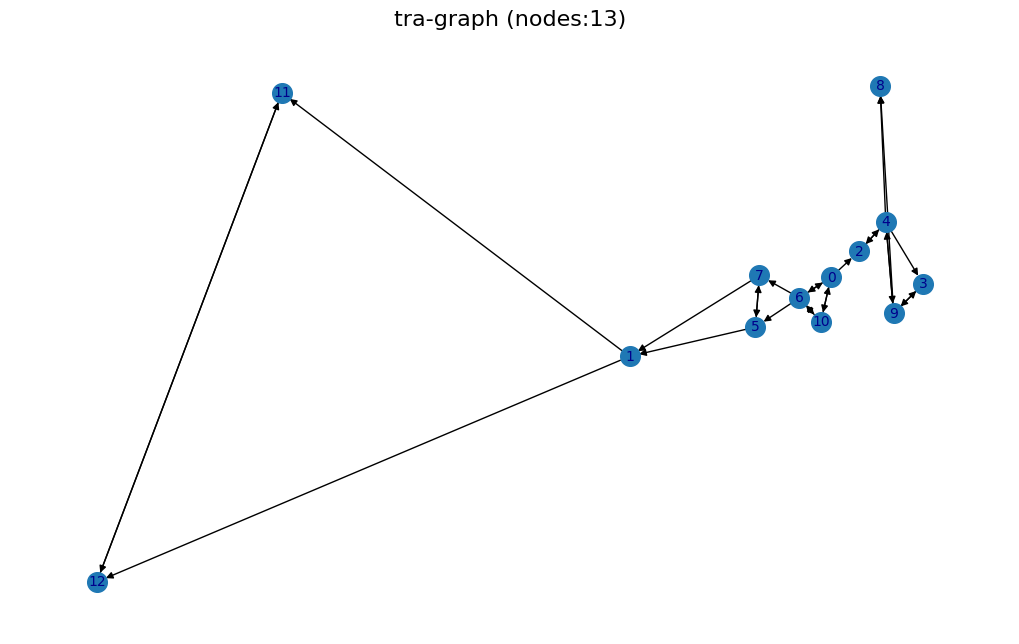

In [10]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

# Convert your graph to NetworkX and prepare positions
pos_dict = {}
for idx, pos in enumerate(tra_graph.location_info[:, :2]):
    pos_dict[idx] = pos.numpy()

G_tra = to_networkx(tra_graph, to_undirected=False)

# Plot the graph
plt.figure(figsize=(10, 6))

# Draw nodes and edges with better visualization parameters
nx.draw(
    G_tra,
    pos=pos_dict,
    with_labels=True,
    node_size=200,  # Increase node size
    # node_color='blue',  # Set node color
    # edge_color='gray',  # Set edge color
    width=1,  # Make edges thicker
    font_size=10,  # Set font size for labels
    font_color='darkblue',  # Set font color for labels
    arrows=True,  # Enable arrows
    arrowsize=10,  # Increase arrow size
    arrowstyle='-|>',  # Use a solid arrow style
)

plt.title(f'tra-graph (nodes:{tra_graph.num_nodes})', fontsize=16)
plt.show()


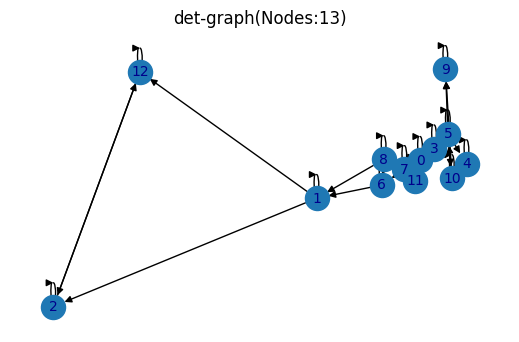

In [18]:
pos_dict = {}
for idx , pos in enumerate(det_graph.location_info[:,:2]):
    pos_dict[idx] = pos.numpy()

G_det = to_networkx(det_graph, to_undirected=False)
plt.figure(figsize=(5, 3))
nx.draw(
    G_det,
    pos=pos_dict,
    with_labels=True,
    node_size=300,  # Increase node size
    # node_color='blue',  # Set node color
    # edge_color='gray',  # Set edge color
    width=1,  # Make edges thicker
    font_size=10,  # Set font size for labels
    font_color='darkblue',  # Set font color for labels
    arrows=True,  # Enable arrows
    arrowsize=10,  # Increase arrow size
    arrowstyle='-|>',  # Use a solid arrow style
)

# nx.draw(G_det,with_labels=True,pos=pos_dict)
plt.title(f'det-graph(Nodes:{det_graph.num_nodes})')
plt.show()

In [11]:
det_graph,tra_graph

(Data(x=[94, 32], location_info=[94, 8], edge_index=[2, 282], edge_attr=[282, 18]),
 Data(x=[94, 32], location_info=[94, 8], edge_index=[2, 282], edge_attr=[282, 18]))

## 1.4  真值矩阵可视化

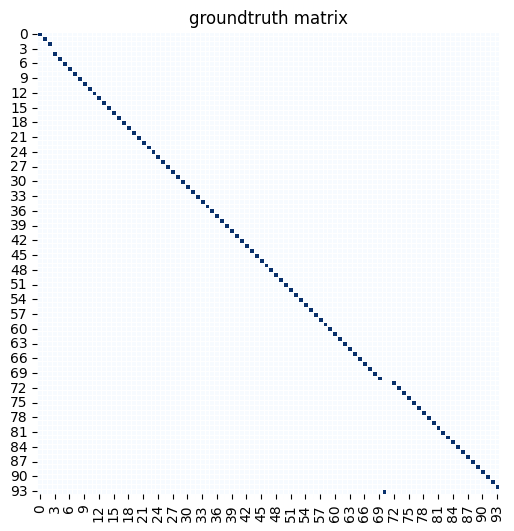

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F 

plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(gt_matrix, annot=False, cmap='Blues', cbar=False, linewidths=0.5, square=True)

# 添加标题
plt.title("groundtruth matrix")

# 显示图像
plt.show()

## 1.5 graphconv可视化

In [13]:
#---------------------------------#
#  tra-graph first
#---------------------------------#
node_embedding = tra_graph.x
edge_embedding = tra_graph.edge_attr
edge_index     = tra_graph.edge_index

node_embedding_sg1 = model.graphconvLayer.sg1Func(node_embedding,edge_index,edge_embedding)      # torch.Size([32, 32])
node_embedding_sg2 = model.graphconvLayer.sg2Func(node_embedding_sg1,edge_index,edge_embedding)  # torch.Size([32, 64])
node_embedding_sg3 = model.graphconvLayer.sg3Func(node_embedding_sg2,edge_index,edge_embedding)  # torch.Size([32, 96])


node_embedding_dg1 = model.graphconvLayer.dg1Func(node_embedding_sg1,cfg.K_NEIGHBOR)  # torch.Size([32,64])
node_embedding_dg2 = model.graphconvLayer.dg2Func(node_embedding_dg1,cfg.K_NEIGHBOR)  # torch.Size([32, 96])


node_embedding_cat1  = torch.cat([node_embedding_sg1,node_embedding_dg1,node_embedding_dg2,
                                    node_embedding_sg2,node_embedding_sg3],dim=1)     # torch.Size([32, 352])
node_embedding_fuse1 = model.graphconvLayer.fuse1Func(node_embedding_cat1)  # torch.Size([32, 1024])
node_embedding_cat2  = torch.cat([node_embedding_fuse1,node_embedding_cat1],dim=1)  # torch.Size([32, 1376])
node_embedding_output_tra= model.graphconvLayer.fuse2Func(node_embedding_cat2)  # torch.Size([32, 128])

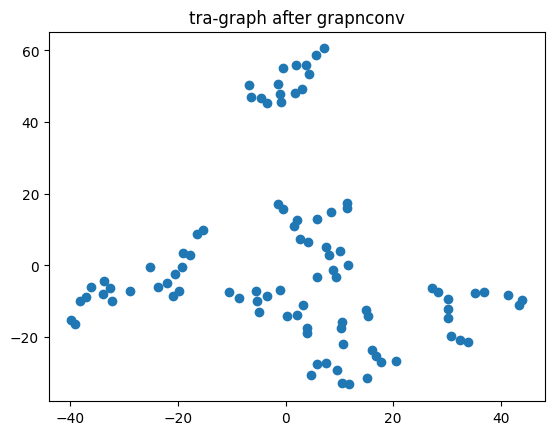

In [14]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 node_embedding_output 是你的嵌入向量
embeddings = node_embedding_output_tra.cpu().detach().numpy()

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=0,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)
plt.title('tra-graph after grapnconv')
# 绘制嵌入向量
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()


In [15]:
#---------------------------------#
#  det-graph first
#---------------------------------#
node_embedding = det_graph.x
edge_embedding = det_graph.edge_attr
edge_index     = det_graph.edge_index

node_embedding_sg1 = model.graphconvLayer.sg1Func(node_embedding,edge_index,edge_embedding)      # torch.Size([32, 32])
node_embedding_sg2 = model.graphconvLayer.sg2Func(node_embedding_sg1,edge_index,edge_embedding)  # torch.Size([32, 64])
node_embedding_sg3 = model.graphconvLayer.sg3Func(node_embedding_sg2,edge_index,edge_embedding)  # torch.Size([32, 96])


node_embedding_dg1 = model.graphconvLayer.dg1Func(node_embedding_sg1,cfg.K_NEIGHBOR)  # torch.Size([32,64])
node_embedding_dg2 = model.graphconvLayer.dg2Func(node_embedding_dg1,cfg.K_NEIGHBOR)  # torch.Size([32, 96])


node_embedding_cat1  = torch.cat([node_embedding_sg1,node_embedding_dg1,node_embedding_dg2,
                                    node_embedding_sg2,node_embedding_sg3],dim=1)     # torch.Size([32, 352])
node_embedding_fuse1 = model.graphconvLayer.fuse1Func(node_embedding_cat1)  # torch.Size([32, 1024])
node_embedding_cat2  = torch.cat([node_embedding_fuse1,node_embedding_cat1],dim=1)  # torch.Size([32, 1376])
node_embedding_output_det= model.graphconvLayer.fuse2Func(node_embedding_cat2)  # torch.Size([32, 128])

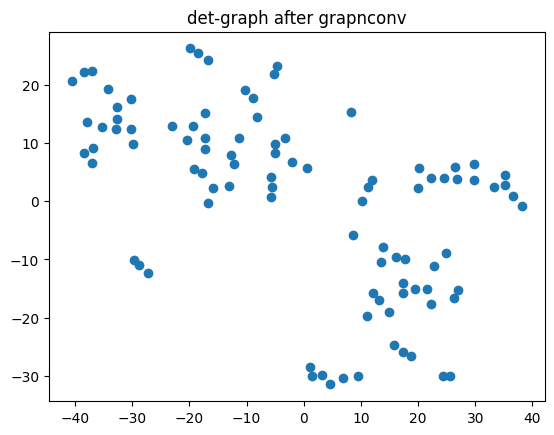

In [16]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 node_embedding_output 是你的嵌入向量
embeddings = node_embedding_output_det.cpu().detach().numpy()

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=0,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)
plt.title('det-graph after grapnconv')
# 绘制嵌入向量
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()


## 1.6 匹配矩阵可视化

In [37]:
corr = torch.mm(node_embedding_output_tra,node_embedding_output_det.transpose(1,0))
n1   = torch.norm(node_embedding_output_tra,dim=-1,keepdim=True)
n2   = torch.norm(node_embedding_output_det,dim=-1,keepdim=True)
cost = - corr / torch.mm(n1,n2.transpose(1,0))  

# 2. Prepare the augmented cost matrix for Sinkhorn
m , n = cost.shape
bins0 = model.alpha.expand(m, 1)
bins1 = model.alpha.expand(1, n)
alpha = model.alpha.expand(1, 1)
couplings = torch.cat([torch.cat([cost,bins0],dim=-1),
                        torch.cat([bins1,alpha],dim=-1)],dim=0)
# # norm  = 1 / (m+n)  
a_aug = torch.full((m+1,),1,dtype=torch.float32) 
b_aug = torch.full((n+1,),1,dtype=torch.float32) 
# a = torch.full((m,),0.95,dtype=torch.float32) 
# b = torch.full((n,),0.95,dtype=torch.float32) 
# a_aug[-1] = 0.95
# b_aug[-1] = 0.95

# pred_mtx = self.sinkhornLayer(couplings,a_aug,b_aug,
#                             self.sinkhorn_iters,torch.exp(self.eplison) + 0.03)


# to original possibility space 
pred_mtx = model.sinkhornLayer(couplings,a_aug,b_aug,
                            #   lambd_sink = torch.exp(self.eplison) + 0.03) * (m + n)
                                lambd_sink = torch.exp(model.eplison) + 0.03)

Text(0.5, 1.0, 'affinity matrix')

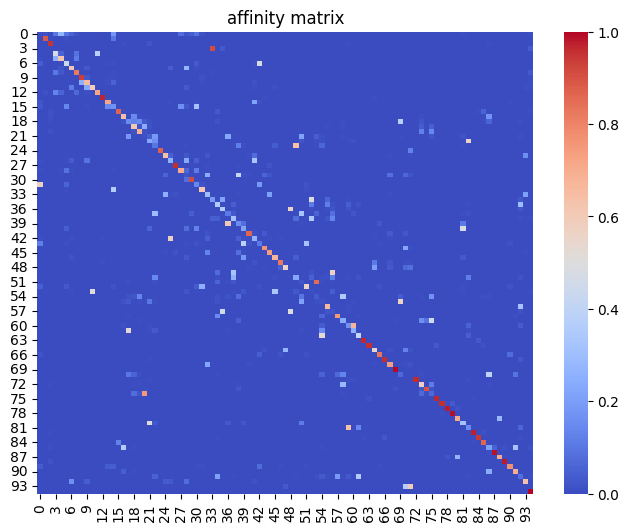

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # 设置热图大小
sns.heatmap(pred_mtx[:,:].detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("affinity matrix")

# torch.sum(pred_mtx, dim=1),torch.sum(pred_mtx, dim=0),

Text(0.5, 1.0, 'assignment matrix')

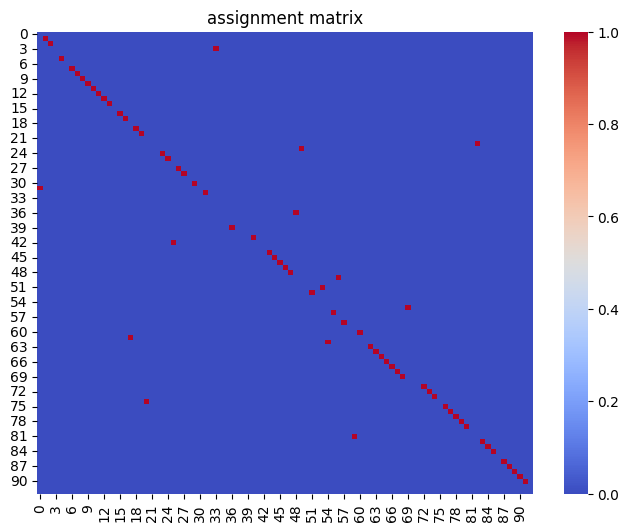

In [39]:
from models.graphToolkit import hungarian

match_mtx,match_idx,unmatch_tra,unmatch_det = hungarian(pred_mtx.detach(),0.5)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # 设置热图大小
sns.heatmap(match_mtx[:-1,:-1], cmap='coolwarm', cbar=True)

# 添加标题
plt.title("assignment matrix")

# torch.sum(pred_mtx, dim=1),torch.sum(pred_mtx, dim=0),

In [ ]:
import numpy as np 
TP = np.sum(np.logical_and(match_mtx == 1, gt_matrix.numpy() == 1))
FP = np.sum(np.logical_and(match_mtx == 1, gt_matrix.numpy() == 0))
FN = np.sum(np.logical_and(match_mtx == 0, gt_matrix.numpy() == 1))

# Precision
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Recall
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# F1 Score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
f1_score

0.6625766871165644

# 2. 假如用这个网络来分辨出跟踪的同一个目标，进行可视化

In [31]:

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from configs.config import get_config
from models.graphModel import GraphModel
from utils.graphDataset import GraphDataset
cfg = get_config()
model = GraphModel(cfg)
# test_dataset = GraphDataset(cfg,'Train',True)
# checkpoint = torch.load(r'experiments\checkpoints\latest.pth')
checkpoint = torch.load(r'experiments\checkpoints\bestScore(1.0)_epoch(86).pth')
model.load_state_dict(checkpoint["model"], strict=False)

<All keys matched successfully>

# 3. 统计 在不同帧率下，同一目标移动的像素均值（包括 移动视角与静止视角）

In [ ]:
#---------------------------------#
#  data - whole dataset [MOT17,MOT20,DanceTrack]
#---------------------------------#

import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

lifespan = 9
dataset_type = {
    'MOT17': ['train'],
    'MOT20': ['train'],
    'DanceTrack': ['train','val']
}
# output_file = os.path.join(,'avgMovement.xlsx')
output_folder = os.path.join('experiments','statisticalData','avgMovement',f'windowSize[{lifespan}]')
os.makedirs(output_folder,exist_ok=True)
output_result = {}
maxvalue_list = []
maxvalue_seq = []

def calculate_average_movement(df, lifespan):
    results = []

    for id_, group in df.groupby('id'):
        # 获取当前目标的中心点坐标
        centers = group[['frame', 'center_x', 'center_y']].reset_index(drop=True)
        n_frames = len(centers)

        # 计算每个lifespan范围内的均值
        for start_frame in range(1, n_frames - lifespan + 1):
            end_frame = start_frame + lifespan - 1
            sub_group = centers[(centers['frame'] >= start_frame) & (centers['frame'] <= end_frame)]

            # 计算x, y坐标的平均移动距离
            displacements = np.sqrt(
                (sub_group['center_x'].diff().iloc[1:].values ** 2) + (sub_group['center_y'].diff().iloc[1:].values ** 2)
            )
            avg_displacement = displacements.mean() if len(displacements) > 0 else 0
            results.append({'id': id_, 'frame_range': f'{start_frame}-{end_frame}', 'avg_displacement': avg_displacement})

    return pd.DataFrame(results)

for dataset in dataset_type.keys():
    for sub_folder in dataset_type[dataset]:
        sub_folder_path = os.path.join('datasets',dataset,sub_folder)
        maxvalue_seq = []
        for seq in os.listdir(sub_folder_path):
            if not os.path.isdir(os.path.join(sub_folder_path,seq)):
                 continue
            gt_path   = os.path.join(sub_folder_path,seq,'gt','gt.txt')
            info_path = os.path.join(sub_folder_path,seq,'seqinfo.ini')
            with open(info_path,'r') as f:
                lines_split = [ l.split('=') for l in f.read().splitlines()[1:]]
                info_dict  = dict(s for s in lines_split if isinstance(s,list) and len(s) == 2)
            print(f"seq[{seq}] info: framerate[{info_dict['frameRate']}], height[{info_dict['imHeight']}], width[{info_dict['imWidth']}]")
            data = np.loadtxt(gt_path,delimiter=',')
            df = pd.DataFrame(data, columns=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'ignore1', 'obj_type', 'ignore3'])
            df = df[df['obj_type'].isin([1,2,7])]
            df['center_x'] = df['bb_left'] + df['bb_width']  / 2
            df['center_y'] = df['bb_top']  + df['bb_height'] / 2
            df = df.sort_values(by=['id', 'frame'])

            result = calculate_average_movement(df, lifespan)

            output_result[seq] = result[result['avg_displacement'] != 0]
            meanvalue = result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].mean().mean()
            maxvalue  = result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].max().max()
            maxvalue_seq.append(maxvalue)
            maxvalue_list.append(maxvalue)
            print(f"seq[{seq}] mean movement:[{meanvalue:.4f}], max movement:[{maxvalue:.4f}] ")
    #         break
        # break
    # break
        # 绘制当前序列的最大移动距离柱状图
        plt.figure(figsize=(10, 6))
        mean_value = np.mean(maxvalue_seq)
        plt.bar(range(len(maxvalue_seq)), maxvalue_seq, color='blue',label='Max Movement')
        for i, v in enumerate(maxvalue_seq):
            plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
        plt.axhline(y=mean_value, color='r', linestyle='--',label=f'mean:{mean_value:.2f}') 
        # plt.text(len(maxvalue_seq) - 1, mean_value, f'Mean: {mean_value:.2f}', ha='right', va='bottom')  # 标注均值
        # plt.xlabel('Sequence')
        plt.legend()
        plt.ylabel('Max Movement')
        plt.title(f'Max Movement for Sequence {dataset}({sub_folder}) || WindowSize {lifespan}')
        plt.xticks(range(len(maxvalue_seq)), [f'Seq {i}' for i in range(1, len(maxvalue_seq) + 1)])
        plt.savefig(os.path.join(output_folder,f'maxMovement_{dataset}({sub_folder})-Window_{lifespan}.png'))
        plt.close()
plt.figure(figsize=(10, 6))
mean_value = np.mean(maxvalue_list)
plt.bar(range(len(maxvalue_list)), maxvalue_list, color='green',label='Max Movement')
for i, v in enumerate(maxvalue_list):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.axhline(y=mean_value, color='r', linestyle='--',label=f'mean:{mean_value:.2f}') 
# plt.text(len(maxvalue_list) - 1, mean_value, f'Mean: {mean_value:.2f}', ha='right', va='bottom')  # 标注均值
# plt.xlabel('Sequence')
plt.legend()
plt.ylabel('Max Movement')
plt.title(f'Max Movement for All Sequences || WindowSize {lifespan}')
plt.xticks(range(len(maxvalue_list)), [f'Seq {i}' for i in range(1, len(maxvalue_list) + 1)])
plt.savefig(os.path.join(output_folder,f'maxMovement_all-Window_{lifespan}.png'))
plt.close()


# so large file that cannot save 
# output_df = pd.concat(output_result.values(), keys=output_result.keys())
# output_df.to_excel(output_file)
          

seq[MOT17-02] info: framerate[30], height[1080], width[1920]
seq[MOT17-02] mean movement:[1.5088], max movement:[18.7438] 
seq[MOT17-04] info: framerate[30], height[1080], width[1920]
seq[MOT17-04] mean movement:[1.1787], max movement:[6.9131] 
seq[MOT17-05] info: framerate[14], height[480], width[640]
seq[MOT17-05] mean movement:[3.7796], max movement:[25.8834] 
seq[MOT17-09] info: framerate[30], height[1080], width[1920]
seq[MOT17-09] mean movement:[8.4692], max movement:[52.1891] 
seq[MOT17-10] info: framerate[30], height[1080], width[1920]
seq[MOT17-10] mean movement:[5.7172], max movement:[29.6629] 
seq[MOT17-11] info: framerate[30], height[1080], width[1920]
seq[MOT17-11] mean movement:[5.8620], max movement:[27.3527] 
seq[MOT17-13] info: framerate[25], height[1080], width[1920]
seq[MOT17-13] mean movement:[5.4997], max movement:[18.4907] 
seq[MOT20-01] info: framerate[25], height[1080], width[1920]
seq[MOT20-01] mean movement:[2.5073], max movement:[10.0444] 
seq[MOT20-02] info:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lifespan remains defined but is not used in the updated context
lifespan = 9
dataset_type = {
    'MOT17': ['train'],
    'MOT20': ['train'],
    'DanceTrack': ['train', 'val']
}

output_folder = os.path.join('experiments', 'statisticalData', 'targetCounts')
os.makedirs(output_folder, exist_ok=True)
output_result = {}

def calculate_frame_target_counts(df):
    # Group by frame and count the number of unique IDs (targets) in each frame
    frame_counts = df.groupby('frame')['id'].nunique()
    return frame_counts

# Initialize lists to store overall statistics for all datasets
all_mean_values = []
all_max_values = []
all_min_values = []

for dataset in dataset_type.keys():
    dataset_mean_values = []
    dataset_max_values = []
    dataset_min_values = []

    for sub_folder in dataset_type[dataset]:
        sub_folder_path = os.path.join('datasets', dataset, sub_folder)
        seq_stats = []

        for seq in os.listdir(sub_folder_path):
            if not os.path.isdir(os.path.join(sub_folder_path, seq)):
                continue

            gt_path = os.path.join(sub_folder_path, seq, 'gt', 'gt.txt')
            info_path = os.path.join(sub_folder_path, seq, 'seqinfo.ini')

            with open(info_path, 'r') as f:
                lines_split = [l.split('=') for l in f.read().splitlines()[1:]]
                info_dict = dict(s for s in lines_split if isinstance(s, list) and len(s) == 2)

            print(f"seq[{seq}] info: framerate[{info_dict['frameRate']}], height[{info_dict['imHeight']}], width[{info_dict['imWidth']}]")
            data = np.loadtxt(gt_path, delimiter=',')
            df = pd.DataFrame(data, columns=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'ignore1', 'obj_type', 'ignore3'])
            df = df[df['obj_type'].isin([1, 2, 7])]
            df = df.sort_values(by=['id', 'frame'])

            # Calculate frame target counts
            frame_counts = calculate_frame_target_counts(df)

            # Compute statistics for the current sequence
            mean_value = frame_counts.mean()
            max_value = frame_counts.max()
            min_value = frame_counts.min()

            dataset_mean_values.append(mean_value)
            dataset_max_values.append(max_value)
            dataset_min_values.append(min_value)

            seq_stats.append({'seq': seq, 'mean': mean_value, 'max': max_value, 'min': min_value})

            print(f"seq[{seq}] mean targets per frame: [{mean_value:.4f}], max targets: [{max_value:.4f}], min targets: [{min_value:.4f}]")

            # Plot histogram of frame target counts for the current sequence
            plt.figure(figsize=(10, 6))
            plt.hist(frame_counts, bins=20, color='blue', alpha=0.7, label='Frame Target Counts')
            plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
            plt.xlabel('Number of Targets per Frame')
            plt.ylabel('Frequency')
            plt.title(f'Target Count Distribution for {dataset} - {sub_folder} - {seq}')
            plt.legend()
            plt.savefig(os.path.join(output_folder, f'{dataset}_{sub_folder}_{seq}_target_count_histogram.png'))
            plt.close()

        # Save per-sequence statistics to a CSV file
        seq_stats_df = pd.DataFrame(seq_stats)
        seq_stats_df.to_csv(os.path.join(output_folder, f'{dataset}_{sub_folder}_seq_stats.csv'), index=False)

    # Aggregate statistics for the entire dataset
    overall_mean = np.mean(dataset_mean_values)
    overall_max = np.max(dataset_max_values)
    overall_min = np.min(dataset_min_values)

    all_mean_values.extend(dataset_mean_values)
    all_max_values.extend(dataset_max_values)
    all_min_values.extend(dataset_min_values)

    print(f"Dataset [{dataset}] overall mean targets per frame: [{overall_mean:.4f}], max targets: [{overall_max:.4f}], min targets: [{overall_min:.4f}]")

    # Save dataset-level statistics to a CSV file
    dataset_stats_df = pd.DataFrame({
        'mean': dataset_mean_values,
        'max': dataset_max_values,
        'min': dataset_min_values
    })
    dataset_stats_df.to_csv(os.path.join(output_folder, f'{dataset}_overall_stats.csv'), index=False)

# Compute overall statistics for all datasets
final_mean = np.mean(all_mean_values)
final_max = np.max(all_max_values)
final_min = np.min(all_min_values)

print(f"Overall mean targets per frame: [{final_mean:.4f}], max targets: [{final_max:.4f}], min targets: [{final_min:.4f}]")

# Save overall statistics to a CSV file
final_stats_df = pd.DataFrame({
    'mean': all_mean_values,
    'max': all_max_values,
    'min': all_min_values
})
final_stats_df.to_csv(os.path.join(output_folder, 'final_overall_stats.csv'), index=False)



seq[MOT17-02] info: framerate[30], height[1080], width[1920]
seq[MOT17-02] mean targets per frame: [42.3350], max targets: [48.0000], min targets: [32.0000]
seq[MOT17-04] info: framerate[30], height[1080], width[1920]
seq[MOT17-04] mean targets per frame: [49.8619], max targets: [56.0000], min targets: [45.0000]
seq[MOT17-05] info: framerate[14], height[480], width[640]
seq[MOT17-05] mean targets per frame: [8.6404], max targets: [15.0000], min targets: [4.0000]
seq[MOT17-09] info: framerate[30], height[1080], width[1920]
seq[MOT17-09] mean targets per frame: [11.1219], max targets: [14.0000], min targets: [6.0000]
seq[MOT17-10] info: framerate[30], height[1080], width[1920]
seq[MOT17-10] mean targets per frame: [21.7355], max targets: [29.0000], min targets: [15.0000]
seq[MOT17-11] info: framerate[30], height[1080], width[1920]
seq[MOT17-11] mean targets per frame: [10.5756], max targets: [19.0000], min targets: [7.0000]
seq[MOT17-13] info: framerate[25], height[1080], width[1920]
seq

# 4. 绘制不同K下的HOTA曲线

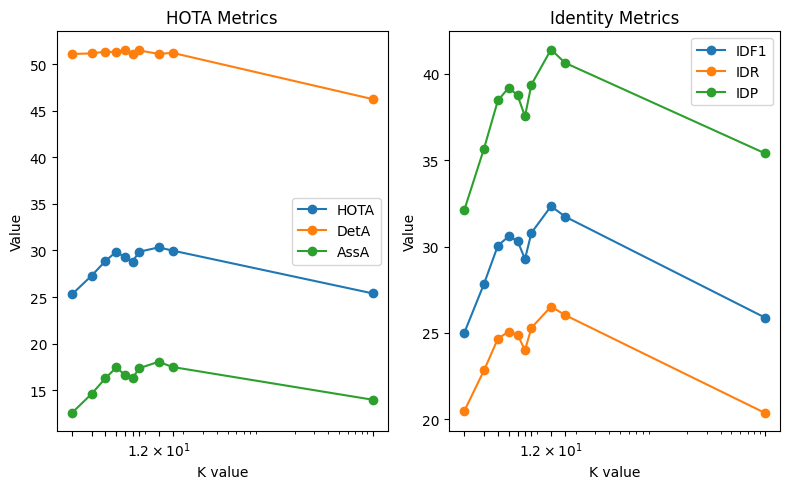

In [134]:
import matplotlib.pyplot as plt

# 创建一个包含所有字典的列表
KFamily ={
    2:[25.29,51.08,12.57,25.02,20.49,32.13,50.01,83.86],
    3:[27.29,51.14,14.61,27.84,22.83,35.67,52.56,83.82],
    4:[28.87,51.33,16.30,30.06,24.67,38.46,53.53,83.85],
    5:[29.87,51.27,17.45,30.59,25.08,39.20,53.46,83.82],
    6:[29.25,51.56,16.64,30.33,24.91,38.76,53.76,83.81],
    7:[28.79,51.10,16.27,29.28,24.00,37.54,53.00,83.81],
    8:[29.86,51.46,17.36,30.80,25.30,39.38,54.10,83.81],
    12:[30.33,51.09,18.06,32.34,26.53,41.41,53.21,83.82],
    16:[29.99,51.20,17.50,31.74,26.04,40.64,52.63,83.79],
    999:[25.40,46.24,13.99,25.89,20.37,35.40,42.60,83.76],
}
# 创建一个包含所有指标的列表
metrics = ['HOTA', 'DetA', 'AssA', 'IDF1', 'IDR', 'IDP']
# 创建一个新的figure
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

# 绘制HOTA, DetA, AssA的折线图
for i, metric in enumerate(metrics):
    if i <3:
        idx = 0
        title = 'HOTA Metrics'
    elif 3 <= i < 6:
        idx = 1
        title = 'Identity Metrics'  
    # values =
    x , y = [] , [] 
    for k,v in KFamily.items():
        x.append(k)
        y.append(v[i])
    axs[idx].plot(x,y, marker='o',label = metric)
    axs[idx].set_title(title)
    axs[idx].set_xlabel('K value')
    axs[idx].set_ylabel('Value')
    axs[idx].set_xscale('log')
    axs[idx].set_xticks(x)
# 显示图例
for ax in axs.flat:
    ax.legend()

# 保存图像
plt.tight_layout()
# plt.savefig('metrics.png')
plt.show()
plt.close()

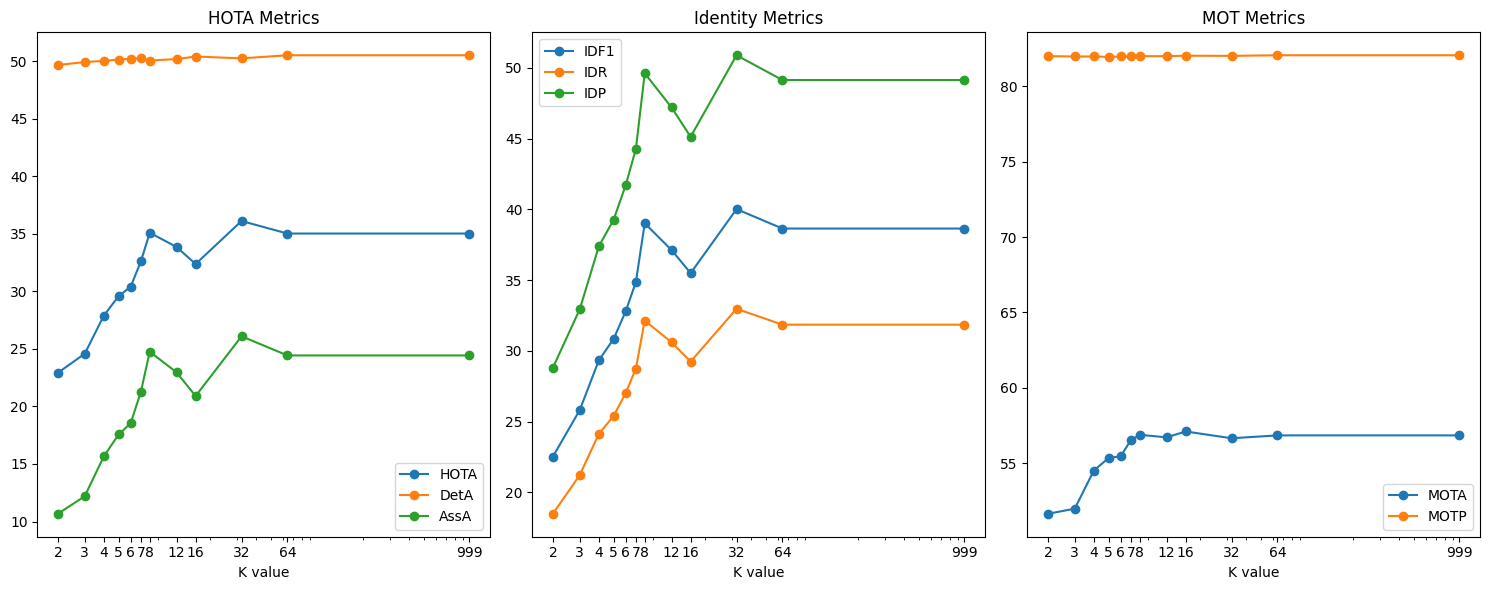

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个包含所有字典的列表
KFamily = {
    2: [22.92 , 49.66 , 10.67 , 22.53 , 18.49 , 28.81 , 51.65 , 82.00 ],
    3: [24.58 , 49.92 , 12.20 , 25.82 , 21.23 , 32.94 , 51.99 , 81.98],
    4: [27.89 , 50.02 , 15.66 , 29.33 , 24.13 , 37.38 , 54.52 , 81.98],
    5: [29.58 , 50.14 , 17.56 , 30.84 , 25.40 , 39.26 , 55.35 , 81.95],
    6: [30.40, 50.20, 18.54, 32.79, 27.01, 41.70, 55.47 ,81.98],
    7: [32.60 , 50.25 , 21.27 , 34.86 , 28.75 , 44.26 , 56.53 , 81.99],
    8: [35.09 , 50.05 , 24.75 , 39.01 , 32.14 , 49.61 , 56.89 , 82.00],
    12: [33.85 , 50.18 , 22.96 , 37.12 , 30.60 , 47.19 , 56.72 , 82.00],
    16: [32.37 , 50.40 , 20.90 , 35.49 , 29.24 , 45.12 , 57.11 , 82.03],
    32: [ 36.11 , 50.24 , 26.09 , 40.01 , 32.97 , 50.88 , 56.66 , 82.02 ],
    64: [ 35.02 , 50.51 , 24.43 , 38.64 , 31.85 , 49.13 , 56.85 , 82.06 ],
    999: [35.02 , 50.51 , 24.43 , 38.64 , 31.85 , 49.13 , 56.85 , 82.06],
}

# 创建一个包含所有指标的列表
metrics = ['HOTA', 'DetA', 'AssA', 'IDF1', 'IDR', 'IDP','MOTA','MOTP']

# 创建一个新的figure
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# 定义 x 的值（K 的值）并排序
x = sorted(KFamily.keys())

# 绘制每个指标的折线图
for i, metric in enumerate(metrics):
    if i < 3:
        idx = 0
        title = 'HOTA Metrics'
    elif 3 <= i < 6:
        idx = 1
        title = 'Identity Metrics'
    else:
        idx = 2
        title = 'MOT Metrics'
    # 提取对应的 y 值
    y = [KFamily[k][i] for k in x]

    # 绘制折线
    axs[idx].plot(x, y, marker='o', label=metric)
    axs[idx].set_title(title)
    axs[idx].set_xlabel('K value')
    # axs[idx].set_ylabel('Value')
    axs[idx].set_xscale('log')  # 设置为对数刻度

    # 设置对数刻度的刻度值
    axs[idx].set_xticks(x)
    axs[idx].get_xaxis().set_major_formatter(plt.ScalarFormatter())
    axs[idx].tick_params(axis='x', rotation=0)  # 旋转刻度标签方便显示

# 显示图例
for ax in axs.flat:
    ax.legend()

# 调整布局
plt.tight_layout()
plt.savefig('.assert/Kfamily_metrics.png')
# 显示图像
plt.show()


# 5.Mask

In [ ]:
import matplotlib.pyplot as plt
metrics = ['HOTA', 'DetA', 'AssA', 'IDF1', 'IDR', 'IDP','MOTA','MOTP']

table = {
    35: [39.53, 52.33, 29.94, 43.65, 36.00, 55.44, 58.03, 83.88],
    50: [40.62, 52.16, 31.73, 44.76, 36.91, 56.85, 57.58, 83.81],
    60: [40.71, 51.99, 31.97, 44.15, 36.41, 56.08, 57.33, 83.86],
    100: [38.51, 51.65, 28.80, 41.37, 34.10, 52.59, 56.25, 83.83],
    150: [33.57, 51.57, 21.92, 34.55, 28.42, 44.06, 52.39, 83.84],
    200: [30.70, 51.61, 18.33, 31.62, 26.00, 40.36, 52.50, 83.87],
    250: [29.50, 51.52, 16.94, 29.38, 24.14, 37.52, 51.14, 83.90],
    300: [29.70, 51.34, 17.24, 30.07, 24.67, 38.48, 52.20, 83.89],
    350: [29.34, 51.30, 16.84, 29.52, 24.23, 37.76, 51.54, 83.83],
    400: [27.60, 51.42, 14.86, 26.91, 22.08, 34.44, 51.39, 83.82],
    450: [27.76, 51.02, 15.15, 27.71, 22.67, 35.64, 50.96, 83.82],
    500: [28.65, 50.92, 16.16, 29.20, 23.90, 37.53, 51.65, 83.78],
    "None": [25.29, 51.08, 12.57, 25.02, 20.49, 32.13, 50.01, 83.86],
}


# 创建一个新的figure
fig, axs = plt.subplots(3, 3, figsize=(15, 6))

# 绘制每个指标的折线图
for cnt in range(3):
    if cnt == 1:
        title = r'Distance Mask '

    for i, metric in enumerate(metrics):    
        if i < 3:
            idx = 0
            title = 'HOTA Metrics'
        elif 3 <= i < 6:
            idx = 1
            title = 'Identity Metrics'
        else:
            idx = 2
            title = 'MOT Metrics'
        # 提取对应的 y 值
        y = [KFamily[k][i] for k in x]

        # 绘制折线
        axs[cnt,idx].plot(x, y, marker='o', label=metric)
        axs[cnt,idx].set_title(title)
        axs[cnt,idx].set_xlabel('Mask Value')
        # axs[idx].set_ylabel('Value')
        axs[cnt,idx].set_xscale('log')  # 设置为对数刻度

        # 设置对数刻度的刻度值
        axs[cnt,idx].set_xticks(x)
        axs[cnt,idx].get_xaxis().set_major_formatter(plt.ScalarFormatter())
        axs[cnt,idx].tick_params(axis='x', rotation=0)  # 旋转刻度标签方便显示

# 显示图例
for ax in axs.flat:
    ax.legend()

# 调整布局
plt.tight_layout()
plt.savefig('.assert/Kfamily_metrics.png')
# 显示图像
plt.show()


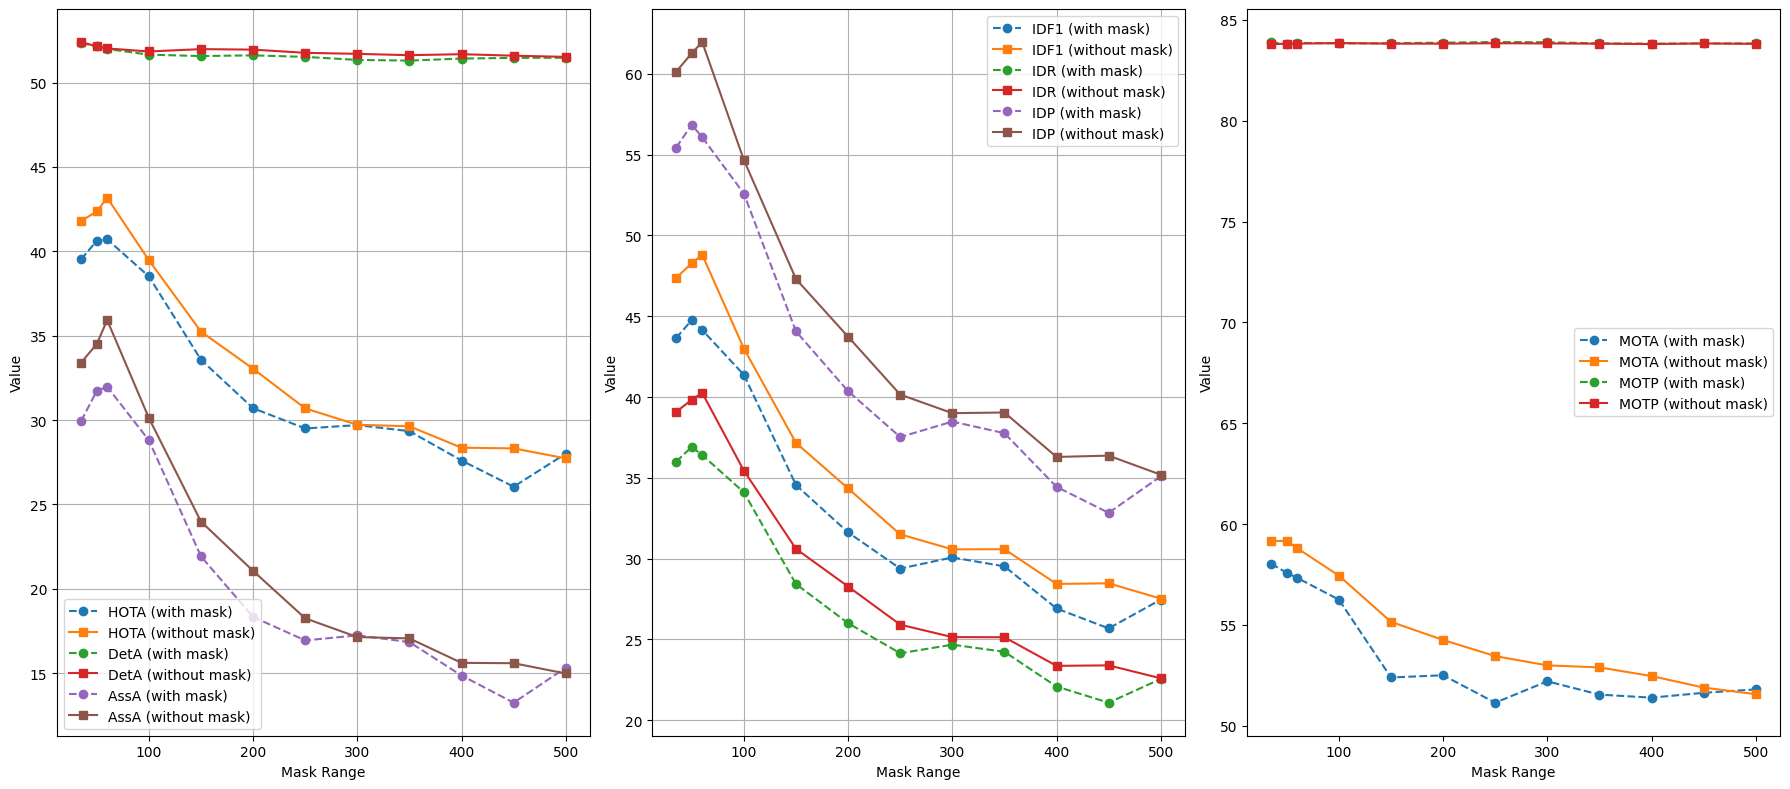

In [168]:
# Fixing the issue with x and y lengths and ensuring consistent plotting
import numpy as np
import matplotlib.pyplot as plt
metrics = ['HOTA', 'DetA', 'AssA', 'IDF1', 'IDR', 'IDP','MOTA','MOTP']

table = {
    35: [39.53, 52.33, 29.94, 43.65, 36.00, 55.44, 58.03, 83.88],
    50: [40.62, 52.16, 31.73, 44.76, 36.91, 56.85, 57.58, 83.81],
    60: [40.71, 51.99, 31.97, 44.15, 36.41, 56.08, 57.33, 83.86],
    100: [38.51, 51.65, 28.80, 41.37, 34.10, 52.59, 56.25, 83.83],
    150: [33.57, 51.57, 21.92, 34.55, 28.42, 44.06, 52.39, 83.84],
    200: [30.70, 51.61, 18.33, 31.62, 26.00, 40.36, 52.50, 83.87],
    250: [29.50, 51.52, 16.94, 29.38, 24.14, 37.52, 51.14, 83.90],
    300: [29.70, 51.34, 17.24, 30.07, 24.67, 38.48, 52.20, 83.89],
    350: [29.34, 51.30, 16.84, 29.52, 24.23, 37.76, 51.54, 83.83],
    400: [27.60, 51.42, 14.86, 26.91, 22.08, 34.44, 51.39, 83.82],
    # 450: [27.76, 51.02, 15.15, 27.71, 22.67, 35.64, 50.96, 83.82],
    450: [26.05,51.46,13.25,25.68,21.08,32.83,51.63,83.83],
    # 500: [28.65, 50.92, 16.16, 29.20, 23.90, 37.53, 51.65, 83.78],
    500: [28.01,51.47,15.32,27.46,22.55,35.09,51.80,83.83],
    # 999: [25.29, 51.08, 12.57, 25.02, 20.49, 32.13, 50.01, 83.86],
}
table_2 = {
    35: [41.80, 52.40, 33.40, 47.37, 39.08, 60.13, 59.16, 83.79],
    50: [42.36, 52.14, 34.51, 48.28, 39.83, 61.28, 59.16, 83.82],
    60: [43.17, 52.02, 35.92, 48.81, 40.26, 61.97, 58.80, 83.82],
    100: [39.47, 51.84, 30.12, 43.00, 35.44, 54.67, 57.44, 83.85],
    150: [35.24, 51.98, 23.98, 37.16, 30.60, 47.30, 55.15, 83.82],
    200: [33.04, 51.95, 21.06, 34.34, 28.27, 43.73, 54.25, 83.82],
    250: [30.69, 51.76, 18.25, 31.50, 25.91, 40.15, 53.45, 83.84],
    300: [29.72, 51.70, 17.14, 30.57, 25.14, 39.00, 52.99, 83.83],
    350: [29.63, 51.62, 17.06, 30.58, 25.13, 39.04, 52.89, 83.82],
    400: [28.36, 51.68, 15.61, 28.43, 23.36, 36.29, 52.46, 83.80],
    450: [28.32,51.59,15.59,28.47,23.39,36.37,51.89,83.83],
    500: [27.73, 51.52, 14.98, 27.52, 22.59, 35.19, 51.56, 83.81],
    # 999: [25.29, 51.08, 12.57, 25.02, 20.49, 32.13, 50.01, 83.86],
}
# Clean x to only include integers
x = [key for key in table.keys() if isinstance(key, int)]

# Function to plot a single table
def plot_table(axs, table, title, row):
    for i, metric in enumerate(metrics):
        y = [table[k][i] for k in table if isinstance(k, int)]  # Filter out non-integer keys
        ax = axs[row, i // 3]  # Determine subplot based on metric index
        ax.plot(x, y, marker='o', label=metric)  # Use cleaned x
        ax.set_title(title if i % 3 == 0 else "")  # Set title only for the first metric in the row
        ax.set_xlabel('Mask Range')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid()

# Function to compare two tables
def plot_comparison(axs, table1, table2, title, row):
    for i, metric in enumerate(metrics):
        y1 = [table1[k][i] for k in table1 if isinstance(k, int)]
        y2 = [table2[k][i] for k in table2 if isinstance(k, int)]
        ax = axs[ i // 3]
        ax.plot(x, y1, marker='o', label=f"{metric} (with mask)", linestyle='--')
        ax.plot(x, y2, marker='s', label=f"{metric} (without mask)", linestyle='-')
        ax.set_title(title if i % 3 == 0 else "")
        ax.set_xlabel('Mask Range')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid()

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 8))

# First row: Table 1
# plot_table(axs, table, "Table 1 Metrics (Trained with Distance Mask)", 0)

# # Second row: Table 2
# plot_table(axs, table_2, "Table 2 Metrics (Trained without Distance Mask)", 1)

# Third row: Comparison
plot_comparison(axs, table, table_2, "Comparison Between Table 1 and Table 2", 0)

# Adjust layout
plt.tight_layout()
plt.savefig('.assert/mask.png')
plt.show()


# 伪造只有一个物体的图，看看图卷积输出

In [ ]:
#---------------------------------#
#  num_nodes 为1 的特殊情况 只在检测器中检测到
#---------------------------------#
import cv2
path = r'datasets\eval_datasets\gt\mot_challenge\MOT17-half\MOT17-13\img1\000093.jpg'
bbox = (99, 571, 81, 179) # SDP
img = cv2.imread(path)
cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 8)

# 显示图片
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite(r'experiments\single(93-MOT17-13).png',img)

In [5]:
import torchvision.io.image as I
from torch_geometric.data import Data
import torchvision.transforms.functional as T


path = r'datasets\eval_datasets\gt\mot_challenge\MOT17-half\MOT17-13\img1\000093.jpg'
bbox = (99, 571, 81, 179) # SDP

im_tensor = I.read_image(path)
img_tensor  = im_tensor.to(torch.float32) / 255.0
raw_node_attr , location_info = [] , []
im_tensor = T.normalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

x , y , w , h = map(int, bbox)
xc , yc   = x + w/2 , y + h/2
x2 , y2   = x + w   , y + h
if x < 0:
    w = w + x  
    x = 0 

if y < 0:
    h = h + y  
    y = 0  
    
w = min(w, im_tensor.shape[2] - x)  
h = min(h, im_tensor.shape[1] - y)

patch = T.crop(im_tensor,y,x,h,w)
patch = T.resize(patch,[256,128])
raw_node_attr.append(patch)
location_info.append([x,y,x2,y2,w,h,xc,yc])

raw_node_attr = torch.stack(raw_node_attr,dim=0)
location_info = torch.as_tensor(location_info,dtype=torch.float32)
sigle_graph = Data(x=raw_node_attr,location_info=location_info)

In [9]:
#---------------------------------#
# 加载模型
#---------------------------------#

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from configs.config import get_config
from models.graphModel import GraphModel
from utils.graphDataset import GraphDataset
cfg = get_config()

model = GraphModel(cfg.MODEL_YAML_PATH)
checkpoint = torch.load(r'model_weights\DA_120epoch.pth',map_location='cpu')
model.load_state_dict(checkpoint["model"], strict=False)
model.eval()

GraphModel(
  (nodeEncoder): NodeEncoder(
    (head): Sequential(
      (0): Sequential(
        (0): ReLU(inplace=True)
        (1): AdaptiveAvgPool2d(output_size=(1, 1))
        (2): Flatten(start_dim=1, end_dim=-1)
      )
      (1): SequentialBlock(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=512, bias=False)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=512, out_features=256, bias=False)
          (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
          (6): Linear(in_features=256, out_features=128, bias=False)
          (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (8): ReLU(inplace=True)
          (9): Linear(in_features=128, out_features=64, bias=False)
          (10): BatchNorm1d(64, eps=1e-05, momentu

In [16]:
#---------------------------------#
#  Node Encoder 
#---------------------------------#
sigle_graph_model =  model.nodeEncoder(sigle_graph.clone())
sigle_graph, sigle_graph_model

(Data(x=[1, 3, 256, 128], location_info=[1, 8]),
 Data(x=[1, 32], location_info=[1, 8]))

In [18]:
#---------------------------------#
# Edge Encoder
#---------------------------------#
sigle_graph_model = model.edgeEncoder(sigle_graph_model,model.k)
sigle_graph_model

2024-12-31 17:48:35.738 | WARNING  | models.graphToolkit:knn:34 - SPECIAL SITUATIONS: The number of points[1] is less than k, set k to 0


Data(x=[1, 32], location_info=[1, 8], edge_index=[2, 1], edge_attr=[1, 16])

In [20]:
sigle_graph_model.edge_index,sigle_graph_model.edge_attr

(tensor([[0],
         [0]]),
 tensor([[0.5164, 0.0000, 0.3848, 0.0000, 1.0998, 1.0877, 0.0000, 0.0000, 0.2969,
          0.4560, 0.0000, 0.0000, 0.0000, 0.3066, 0.6376, 1.1312]],
        grad_fn=<ReluBackward1>))